In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Number of simulations
num_simulations = 1000
#Number of years
num_years = 5

# Import data & create dataframe

In this exercise two datasets will be used. The first one includes historic revenue growth, GDP growth and inflation while the second includes five-year forecasts for GDP growth and inflation. The historic figures where extracted from Fever-Tree annual accounts and the office of national statistics while the forecasted from the October 2020 PWC UK Economic Update.

In [3]:
#read historic data
df = pd.read_csv('data.csv',header=None)
df.columns=['revenue','%gdp_growth','%inflation']
#read forecasted data
df_fct = pd.read_csv('data_fct.csv',header=None)
df_fct.columns=['%gdp_growth_fct','%inflation_fct']

In [4]:
df

,revenue,%gdp_growth,%inflation
0,0.097304,0.015,0.018
1,0.395067,0.013,0.025
2,0.664476,0.019,0.027
3,0.725461,0.019,0.007
4,0.707993,0.024,0.004
5,0.488756,0.026,0.015
6,0.438395,0.021,0.026
7,0.350000,0.015,0.028
8,0.791045,0.015,0.045


In [5]:
df_fct

,%gdp_growth_fct,%inflation_fct
0,0.018,0.0162
1,0.018,0.0162
2,0.018,0.0162
3,0.101,0.0150
4,-0.111,0.0050


# Linkage between GDP & inflation, and the revenue growth of Fevertree

A linear relationship is assumed between revenue growth, GDP growth & inflation. Revenue is the dependent variable while GDP growth and inflation are the independent variables.

Multiple linear regression is used to calculate the two coefficients (b2, b1) along and the intercept (b0).

$ y =b ₀+b ₁x ₁+b₂x₂+c$  

Where y is the revenue growth, b0 the intercept, b1 the coefficient for GDP growth and b2 the coefficient for inflation. After calculating the coefficients and the intercept the equation above becomes:

$revenue Growth = 24.92*gdp Growth + 5.62*inflation - 0.06$

In [6]:
# create linear regression object
mlr = LinearRegression()

In [7]:
# fit linear regression
mlr.fit(df[['%gdp_growth', '%inflation']], df['revenue'])

LinearRegression()

In [8]:
intercept = mlr.intercept_
coefficients = mlr.coef_
gdp_coef = coefficients[0]
inf_coef = coefficients[1]

# Functions

In [9]:
def monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct):
    '''Performs the monte carlo simulation and returns a dataframe'''
    simulation_df = pd.DataFrame()
    for x in range(num_simulations):
        count = 0

        ebitda_series = []
        revenue_series = []
        gdp_growth = np.random.normal(loc = gdp_mean, scale = gdp_std)
        inflation = np.random.normal(loc = inf_mean, scale = inf_std)
        revenue_growth = gdp_coef*gdp_growth + inf_coef*inflation
        revenue = last_revenue*(1+revenue_growth)
        revenue_series.append(revenue)
        ebitda = revenue*ebitda_pct
        ebitda_series.append(ebitda)

        for y in range(num_years):
            if count==num_years-1:
                break
            gdp_growth = np.random.normal(loc = gdp_mean, scale = gdp_std)
            inflation = np.random.normal(loc = inf_mean, scale = inf_std)
            revenue_growth = gdp_coef*gdp_growth + inf_coef*inflation
            revenue = revenue_series[count]*(1+revenue_growth)
            revenue_series.append(revenue)
            ebitda = revenue*ebitda_pct
            ebitda_series.append(ebitda)
            count+=1
        simulation_df[x] = ebitda_series
        
    return simulation_df

In [10]:
def createPlot(simulation_df):
    ''' Creates a plot'''
    fig = plt.figure()
    fig.suptitle('Monte Carlo Simulation Fever-Tree')
    plt.plot(simulation_df)
    plt.axhline(y=last_ebitda,color='r',linestyle='-')
    plt.xlabel('Years')
    plt.ylabel('EBITDA')
    plt.show()

# Scenario_1 - Covid Never Happened

The first scenario assumes that covid did occur and as a result there will be no major fluctuations on UK GDP or Inflation. Moreover, we use the following assumptions:

* GDP Growth follows a normal distribution with mean equal to 1.8% and a standard deviation equal to 0.44% (based on past 9 years GDP growth). 
* Inflation follows a normal distribution with mean 2.1% and standard deviation of 1.2% (based on inflation of the past 9 years)
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years)
* Inflation and GDP are independent e.g. changes in inflation does not affect GDP and vice versa.

In [11]:
# standard deviation of gdp growth and inflation
gdp_std = df['%gdp_growth'].std()
inf_std = df['%inflation'].std()
#mean of gdp and inflation
gdp_mean = df['%gdp_growth'].mean()
inf_mean = df['%inflation'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [12]:
simulation_df = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [13]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,142.871389,123.552690,147.415684,120.147779,137.265963,137.985732,103.280241,149.331523,142.216300,140.400260,...,129.548482,125.580827,129.427883,134.044301,135.256729,124.416106,125.580312,140.570188,124.482751,154.028054
1,206.482124,175.157425,225.165336,190.072888,222.667185,231.773738,165.610886,229.231924,214.501065,223.808972,...,193.155787,180.079959,207.432072,217.346953,233.881202,215.291855,182.263648,197.002961,191.788214,218.773172
2,297.900879,286.950719,340.789501,297.597204,344.939584,424.882417,263.288946,331.792120,354.450695,353.339858,...,305.595659,256.669927,284.916854,323.056994,424.670213,313.563829,300.339389,324.958008,264.121877,364.657318
3,485.580964,460.151717,563.865837,471.535491,543.086116,608.675600,398.243917,539.665156,510.151073,571.820105,...,484.221293,397.961754,480.941507,494.109583,847.301903,497.999144,467.332638,493.635744,399.490821,606.253226
4,826.119039,819.601942,949.181457,848.158822,863.631617,978.354668,628.691192,905.346329,695.536645,944.578914,...,744.257339,706.913681,763.195358,753.389001,1421.789757,903.983257,742.972987,766.818540,652.630660,1063.233601


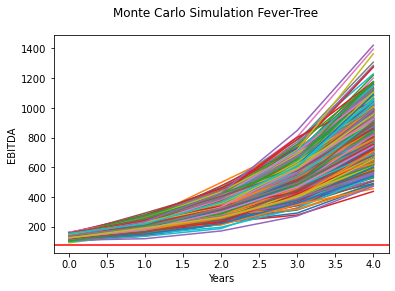

In [14]:
createPlot(simulation_df)

# Scenario_2 - Covid Happened

In [15]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct'].std()
inf_std = df_fct['%inflation_fct'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct'].mean()
inf_mean = df_fct['%inflation_fct'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [16]:
simulation_df = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [18]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-75.023234,98.987273,111.785355,89.297962,-62.532060,73.825095,2.706877,-20.200331,67.627869,45.342068,...,17.458178,182.695468,-31.309948,274.153897,68.738751,13.084502,-46.458758,-231.357559,167.154874,58.376574
1,-272.592140,264.653581,-96.416521,210.033247,-232.751513,107.974808,8.472083,2.973852,-3.655704,134.569701,...,17.706278,649.552754,15.295251,300.134732,55.546587,-9.962067,-120.351472,182.246159,257.581528,194.270662
2,492.005265,2.341243,-162.455128,291.248822,-112.819169,-60.965499,43.612800,1.246905,-2.450170,50.513845,...,-0.873206,-2540.353816,33.054168,265.882800,53.571753,8.914528,382.338426,-649.119525,1213.345609,341.699654
3,392.907842,2.992794,-536.038605,833.710378,24.036728,48.423112,39.616194,5.880198,-0.465460,135.845701,...,-1.911034,995.300186,7.782266,778.980182,66.993311,5.017154,2021.001281,-287.985137,3361.224713,-33.103246
4,164.133738,1.124137,1253.049619,1528.242641,71.119737,-15.449151,21.759035,12.419567,-2.316000,245.140354,...,-4.583099,-540.093778,-2.281316,-588.051004,-109.160620,2.882844,-331.739709,-1386.161543,8273.794449,-122.999213


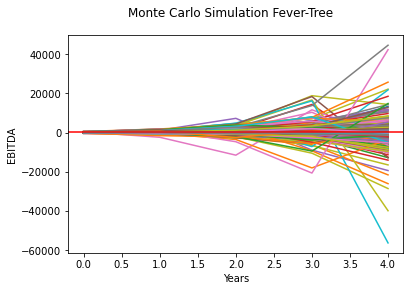

In [17]:
createPlot(simulation_df)